In [1]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import ast
from functools import partial

Use WordNet similarity score to find probabilitiy corresponding to the closest label 

In [2]:
from nltk.corpus import wordnet

In [3]:
# df = pd.read_csv('googlenet_scores_wordnet_id.csv',index_col=0)

Input dataframe columns: (see alexnet.ipynb for getting wordnet ids for corresponding labels)

In [4]:
df.columns

Index(['type', 'dir', 'id_labels', 'readable_labels'], dtype='object')

In [3]:
# manually select the synsnet with the correct definition for each type
type_names = np.unique(df['type'].values)
for t in type_names:
    syns = wordnet.synsets(t.lower())
    if t == 'Beach':
        syns = wordnet.synsets('seashore')
    print(f'{t}: ')
    for s in syns:
        print(s)
        print(s.definition())
    print()

NameError: name 'df' is not defined

In [6]:
type_synsets = ['banana.n.02','beach.n.01','car.n.01','church.n.02','beacon.n.03','mountain.n.01','coffee_mug.n.01','airplane.n.01']
type_final = {type_names[i] : type_synsets[i] for i in range(len(type_names))}

In [7]:
type_final

{'Banana': 'banana.n.02',
 'Beach': 'beach.n.01',
 'Car': 'car.n.01',
 'Church': 'church.n.02',
 'Lighthouse': 'beacon.n.03',
 'Mountain': 'mountain.n.01',
 'Mug': 'coffee_mug.n.01',
 'Plane': 'airplane.n.01'}

In [8]:
# compute similarity score between synsets of each of the top 10 labels and the type 
def getSyns(similarity,closest,row):
    # type name
    category = row['type'] 
    
    # top 10 labels' ids in wordnet
    labels  = row['id_labels'] 
    labels = ast.literal_eval(labels)
    key = labels.keys() 
    
    # iterate through top 10 labels and compare with type 
    sim = dict()
    notFound = True
    for k in key:
        pos, synid = k.split('-')[1], int(k.split('-')[0]) # part of speech (all noun in this case), id
        k_syns = wordnet.synset_from_pos_and_offset(pos, synid) # label synsets
        cat_syns = wordnet.synset(type_final[category]) # type synsets
        s = k_syns.path_similarity(cat_syns)
        sim[k] = s
        
        # find the first > 0.5 similarity label among the top 10
        if s >= 0.5 and notFound:
            closest.append({k:s})
            notFound = False
            
    # return the label with highest probabilitiy if none is above 0.5
    if notFound:
        sim_np = np.array(sim.values())
        max_key = list(key)[np.argmax(sim_np)]
        closest.append({max_key : sim[max_key]})
    
    similarity.append(sim)

In [10]:
# read labels to wordnet synsets
ltw = pd.read_json('../imagenet_label_to_wordnet_synset.json').T

In [11]:
# get readable labels from imagenet_label_to_wordnet_synset.json
def convertIdToReadable(id_label):
    for idx in range(ltw.shape[0]):
        if ltw['id'][idx] == id_label:
            return ltw['label'][idx]
    return None

In [12]:
df

,type,dir,id_labels,readable_labels
0,Mountain,../Image/All_Cropped\Mountain\1.jpg,"{'09332890-n': 0.28545108437538147, '09472597-...","{'lakeside': 0.28545108437538147, 'volcano': 0..."
1,Mountain,../Image/All_Cropped\Mountain\10.jpg,"{'09468604-n': 0.1293070912361145, '09193705-n...","{'valley': 0.1293070912361145, 'alp': 0.073099..."
2,Mountain,../Image/All_Cropped\Mountain\11.jpg,"{'09193705-n': 0.6057558655738831, '09472597-n...","{'alp': 0.6057558655738831, 'volcano': 0.20061..."
3,Mountain,../Image/All_Cropped\Mountain\12.jpg,"{'09193705-n': 0.7249870896339417, '09468604-n...","{'alp': 0.7249870896339417, 'valley': 0.140982..."
4,Mountain,../Image/All_Cropped\Mountain\13.jpg,"{'09246464-n': 0.4255097806453705, '09468604-n...","{'cliff': 0.4255097806453705, 'valley': 0.1114..."
...,...,...,...,...
123,Church,../Image/All_Cropped\Church\5.jpg,"{'03028079-n': 0.40516284108161926, '03781244-...","{'church': 0.40516284108161926, 'monastery': 0..."
124,Church,../Image/All_Cropped\Church\6.jpg,"{'02793495-n': 0.6723809242248535, '02859443-n...","{'barn': 0.6723809242248535, 'boathouse': 0.05..."
125,Church,../Image/All_Cropped\Church\7.jpg,"{'03028079-n': 0.3462732136249542, '03781244-n...","{'church': 0.3462732136249542, 'monastery': 0...."
126,Church,../Image/All_Cropped\Church\8.jpg,"{'03028079-n': 0.3220229148864746, '02814860-n...","{'church': 0.3220229148864746, 'beacon': 0.119..."


In [13]:
similarity = []
closest = []
getSynsPartial = partial(getSyns, similarity, closest)
df.apply(getSynsPartial, axis=1)

df['similarity_score'] = similarity
df['closest_id_label'] = [list(item.keys())[0] for item in closest]
df['closest_similarity_score'] = [list(item.values())[0] for item in closest]
df['closest_readable_label'] = df['closest_id_label'].apply(convertIdToReadable)
df['closest_prob'] = [ast.literal_eval(d)[i] for d, i in zip(df['id_labels'],df['closest_id_label'])]

In [14]:
df

,type,dir,id_labels,readable_labels,similarity_score,closest_id_label,closest_similarity_score,closest_readable_label,closest_prob
0,Mountain,../Image/All_Cropped\Mountain\1.jpg,"{'09332890-n': 0.28545108437538147, '09472597-...","{'lakeside': 0.28545108437538147, 'volcano': 0...","{'09332890-n': 0.2, '09472597-n': 0.5, '094686...",09472597-n,0.5,volcano,0.066258
1,Mountain,../Image/All_Cropped\Mountain\10.jpg,"{'09468604-n': 0.1293070912361145, '09193705-n...","{'valley': 0.1293070912361145, 'alp': 0.073099...","{'09468604-n': 0.2, '09193705-n': 0.5, '093328...",09193705-n,0.5,alp,0.073099
2,Mountain,../Image/All_Cropped\Mountain\11.jpg,"{'09193705-n': 0.6057558655738831, '09472597-n...","{'alp': 0.6057558655738831, 'volcano': 0.20061...","{'09193705-n': 0.5, '09472597-n': 0.5, '094686...",09193705-n,0.5,alp,0.605756
3,Mountain,../Image/All_Cropped\Mountain\12.jpg,"{'09193705-n': 0.7249870896339417, '09468604-n...","{'alp': 0.7249870896339417, 'valley': 0.140982...","{'09193705-n': 0.5, '09468604-n': 0.2, '094725...",09193705-n,0.5,alp,0.724987
4,Mountain,../Image/All_Cropped\Mountain\13.jpg,"{'09246464-n': 0.4255097806453705, '09468604-n...","{'cliff': 0.4255097806453705, 'valley': 0.1114...","{'09246464-n': 0.25, '09468604-n': 0.2, '09193...",09193705-n,0.5,alp,0.078892
...,...,...,...,...,...,...,...,...,...
123,Church,../Image/All_Cropped\Church\5.jpg,"{'03028079-n': 0.40516284108161926, '03781244-...","{'church': 0.40516284108161926, 'monastery': 0...","{'03028079-n': 1.0, '03781244-n': 0.1428571428...",03028079-n,1.0,"church, church building",0.405163
124,Church,../Image/All_Cropped\Church\6.jpg,"{'02793495-n': 0.6723809242248535, '02859443-n...","{'barn': 0.6723809242248535, 'boathouse': 0.05...","{'02793495-n': 0.2, '02859443-n': 0.1666666666...",03028079-n,1.0,"church, church building",0.027058
125,Church,../Image/All_Cropped\Church\7.jpg,"{'03028079-n': 0.3462732136249542, '03781244-n...","{'church': 0.3462732136249542, 'monastery': 0....","{'03028079-n': 1.0, '03781244-n': 0.1428571428...",03028079-n,1.0,"church, church building",0.346273
126,Church,../Image/All_Cropped\Church\8.jpg,"{'03028079-n': 0.3220229148864746, '02814860-n...","{'church': 0.3220229148864746, 'beacon': 0.119...","{'03028079-n': 1.0, '02814860-n': 0.1666666666...",03028079-n,1.0,"church, church building",0.322023


In [15]:
df.loc[4]

type                                                                 Mountain
dir                                      ../Image/All_Cropped\Mountain\13.jpg
id_labels                   {'09246464-n': 0.4255097806453705, '09468604-n...
readable_labels             {'cliff': 0.4255097806453705, 'valley': 0.1114...
similarity_score            {'09246464-n': 0.25, '09468604-n': 0.2, '09193...
closest_id_label                                                   09193705-n
closest_similarity_score                                                  0.5
closest_readable_label                                                    alp
closest_prob                                                        0.0788919
Name: 4, dtype: object

In [16]:
df.loc[9]

type                                                                 Mountain
dir                                       ../Image/All_Cropped\Mountain\3.jpg
id_labels                   {'09288635-n': 0.12307517230510712, '09468604-...
readable_labels             {'geyser': 0.12307517230510712, 'valley': 0.10...
similarity_score            {'09288635-n': 0.2, '09468604-n': 0.2, '091937...
closest_id_label                                                   09193705-n
closest_similarity_score                                                  0.5
closest_readable_label                                                    alp
closest_prob                                                        0.0847823
Name: 9, dtype: object

In [20]:
# df.to_csv('googlenet_scores_wordnet_id_closest_label.csv')

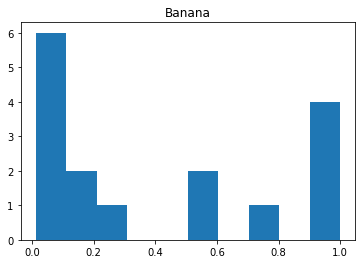

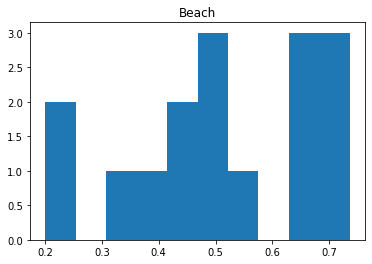

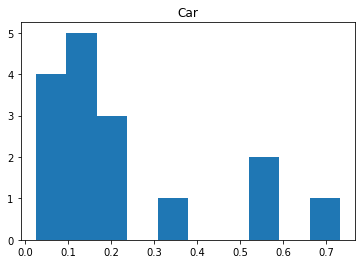

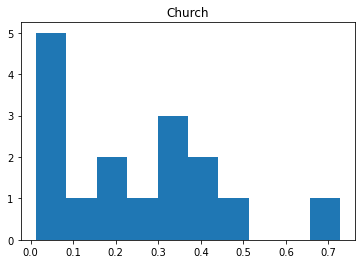

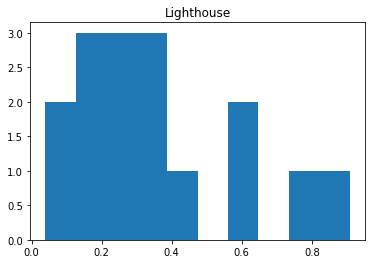

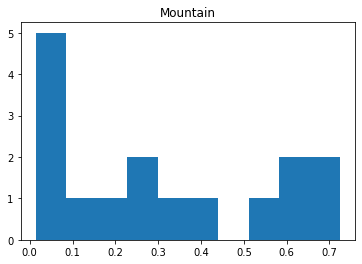

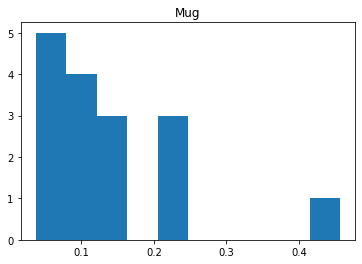

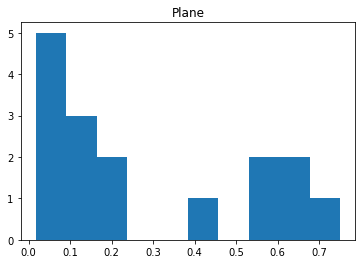

In [19]:
import matplotlib.pyplot as plt

for t in type_names:
    df_plot=df[df['type']==t]
    plt.hist(df_plot['closest_prob'])
    plt.title(t)
    plt.show()

In [21]:
type_names

array(['Banana', 'Beach', 'Car', 'Church', 'Lighthouse', 'Mountain',
       'Mug', 'Plane'], dtype=object)